In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

import warnings
warnings.filterwarnings('ignore')

np.random.seed(2323)

DATA_DIR = './data/'

Two kinds of historical information are given: __sale log__ and __repair log__. The time period of the __sale log__ is from _January/2005_ to _February/2008_; while the time period of the __repair log__ is from _February/2005_ to _December/2009_. Details of these two files are described in the File description section.

Participants should exploit the sale and repair log to predict the the __monthly repair amount__ for each __module-component__ from _January/2010 to July/2011_. In other words, the model should output a series (nineteen elements, one element for one month) of predicted __real-value__ (amount of repair) for each module-component.

In [80]:
# load files
repair_train = pd.read_csv(os.path.join(DATA_DIR, 'RepairTrain.csv'), parse_dates=[2, 3])
sale_train = pd.read_csv(os.path.join(DATA_DIR, 'SaleTrain.csv'), parse_dates=[2])
output_mapping = pd.read_csv(os.path.join(DATA_DIR, 'Output_TargetID_Mapping.csv'))
sample_sub = pd.read_csv(os.path.join(DATA_DIR, 'SampleSubmission.csv'))

In [81]:
repair_train.head()

,module_category,component_category,year/month(sale),year/month(repair),number_repair
0,M6,P16,2007-09-01,2009-04-01,1
1,M2,P30,2007-09-01,2009-08-01,1
2,M1,P12,2006-10-01,2008-02-01,2
3,M1,P30,2006-05-01,2007-07-01,1
4,M3,P06,2007-08-01,2007-12-01,1


In [82]:
sale_train.head()

,module_category,component_category,year/month,number_sale
0,M4,P27,2005-01-01,0
1,M4,P27,2005-05-01,1042
2,M4,P27,2005-09-01,1677
3,M4,P27,2005-10-01,918
4,M4,P27,2005-11-01,0


In [96]:
output_mapping.head()

,module_category,component_category,year,month
0,M1,P02,2010,1
1,M1,P02,2010,2
2,M1,P02,2010,3
3,M1,P02,2010,4
4,M1,P02,2010,5


** How many of the module and component category are in the training set as well ? **

In [60]:
def count_module_components_in_train(df, output_mapping):
    num_mod_comp = 0
    checked = {}
    
    output_mapping_without_duplicates = output_mapping[['module_category', 'component_category']].drop_duplicates()
    
    for mod, comp in zip(output_mapping_without_duplicates['module_category'], output_mapping_without_duplicates['component_category']):
        mask = (df.module_category == mod) & (df.component_category == comp)
        
        if (mod,comp) not in checked  and df.loc[mask].shape[0] > 0:
            num_mod_comp += 1
            checked[(mod, comp)] = True
    
    return num_mod_comp

print('Number of module and component in the repair_train ', count_module_components_in_train(repair_train, output_mapping))
print('Number of module and component in the sale_train ', count_module_components_in_train(sale_train, output_mapping))

Number of module and component in the repair_train  224
Numbe of module and component in the sale_train  224


In [84]:
# add month of the repair as a feature
repair_train['repair_month'] = repair_train['year/month(repair)'].dt.month

** So all of the module and component pairs are present in the sales and repair dataset. **

In [97]:
repair_per_month = repair_train.pivot_table(values='number_repair', index=['module_category', 'component_category'],\
                         columns=['repair_month'], fill_value=0)

### Exponential Decay

For every module and component take numbe of repairs in the month of December to be initial value and then at a decay rate $k$, give predictions for the rest 19 months.

In [98]:
module_component = output_mapping[['module_category', 'component']]

repair_month
1     1.000000
2     1.043478
3     1.000000
4     1.000000
5     1.000000
6     1.000000
7     1.055556
8     1.000000
9     1.000000
10    1.000000
11    1.055556
12    1.062500
Name: (M1, P02), dtype: float64

In [61]:
sale_train.loc[(sale_train.module_category == 'M1') & (sale_train.component_category == 'P02')].shape

(585, 4)

In [62]:
repair_train.loc[(repair_train.module_category == 'M1') & (repair_train.component_category == 'P02')].shape

(191, 5)

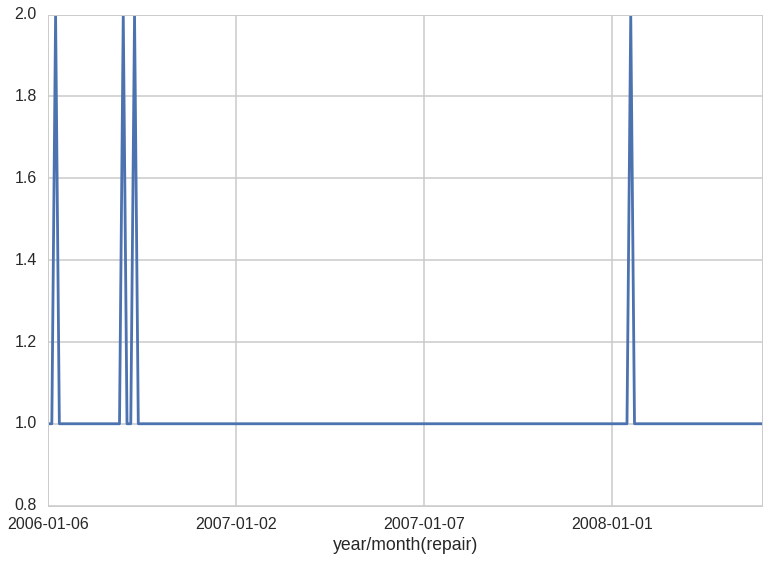

In [44]:
repair_train.loc[(repair_train.module_category == 'M1') & (repair_train.component_category == 'P02'), ['year/month(repair)','number_repair']]\
            .sort_values(by='year/month(repair)').set_index('year/month(repair)')['number_repair'].plot();

In [ ]:
sa